# The Nose Knows
### A Dog Breed Classifier


Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D, RandomHeight, RandomWidth, RandomZoom, RandomRotation, RandomFlip
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
import os
import imghdr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
from wordcloud import WordCloud

C:\Users\kpegg\AppData\Local\Temp\ipykernel_10844\3108969071.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


C:\Users\kpegg\AppData\Local\Temp\ipykernel_10844\3108969071.py:13: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Importing the CSV with labels and the training & test images

In [3]:
train = "data/dog-breed-identification/train"
test = "data/dog-breed-identification/test"
df=pd.read_csv("data/dog-breed-identification/labels.csv")
df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


Exploring the dataset

In [4]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Displaying some photos with labels

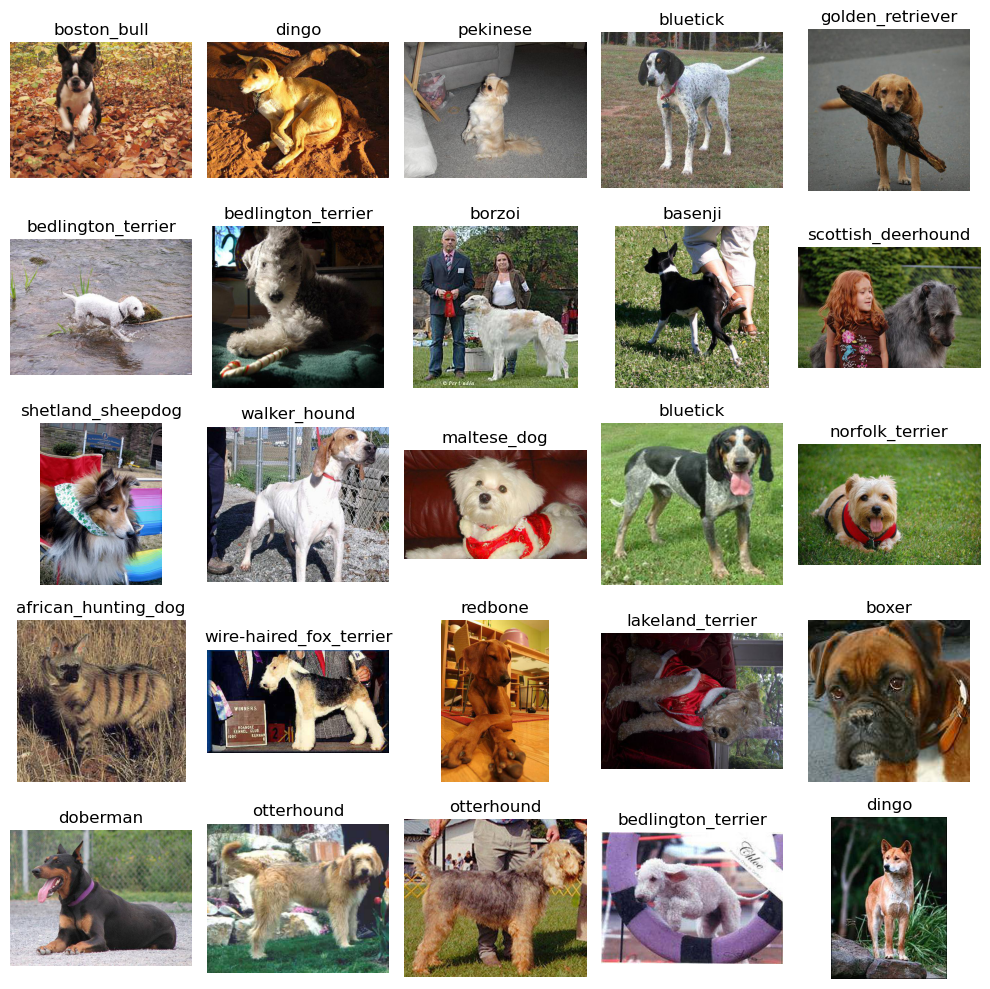

In [5]:
nrow = 5
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 10))

for i, (img_id, breed) in enumerate(df[["id", "breed"]].values[:nrow * ncol]):
    image_path = os.path.join(train, img_id + ".jpg")
    
    # Use PIL to open and convert the image
    image = Image.open(image_path)
    
    # Convert to RGB if the image is not already in RGB mode
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    row = i // ncol
    col = i % ncol
    
    ax[row, col].imshow(image)
    ax[row, col].set_title(breed)
    ax[row, col].axis("off")

plt.tight_layout()
plt.show()

How many dog breeds are in the dataset? Does it match the description from the webiste?

In [6]:
print("Number of unique dog breeds: ", len(df.breed.unique()))

Number of unique dog breeds:  120


Putting the unique dog breeds into a list

In [8]:
labels = df["breed"].unique().tolist()
print(labels)

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz', 'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke', 'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malamute', 'welsh_springer_spaniel', 'chihuahua', 'saluki', 'pug', 'malino

Creating a bar chart of the amount of photos per breed of dog

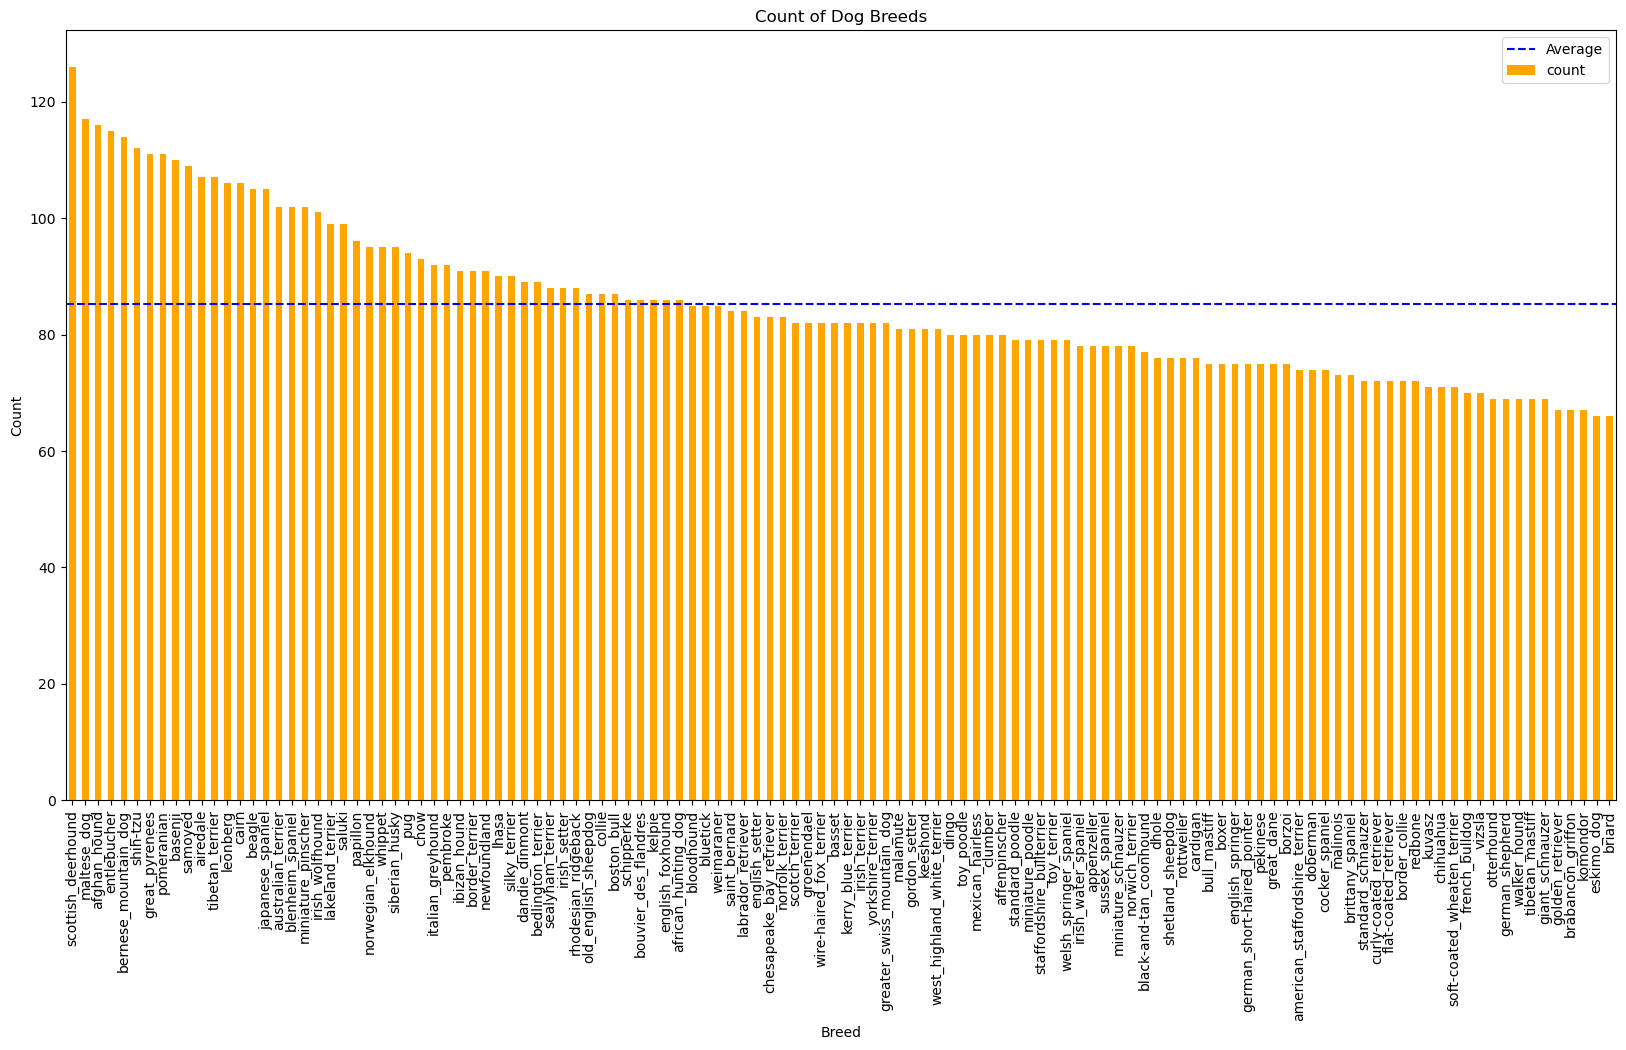

In [10]:
# Plot the bar chart of filname count per breed
ax = df["breed"].value_counts().plot.bar(figsize=(20, 10), color='orange')

# calculate the average value
average_value = df["breed"].value_counts().mean()

# add the average line
ax.axhline(average_value, color='blue', linestyle='--', label='Average')

# Customize the plot as desired
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Count of Dog Breeds')
plt.legend();

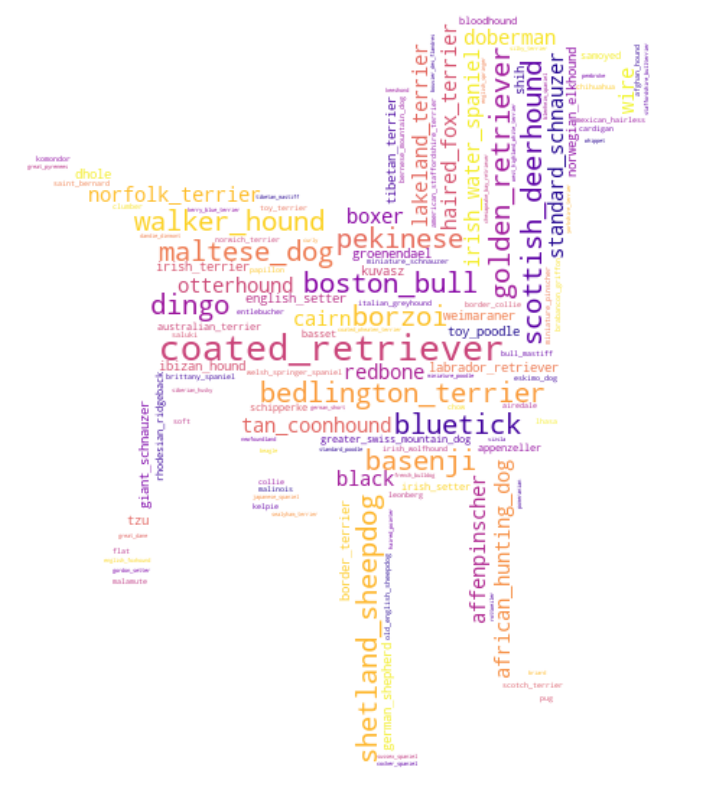

In [24]:
# word cloud of breeds for fun
# join breed names into a single string
text = ' '.join(labels)

mask = np.array(Image.open("data/dog-silhouette.jpg"))

wordcloud = WordCloud(width=600, height=300, 
                      colormap="plasma", 
                      mask=mask, 
                      background_color='white'
                      ).generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Adding a column in the dataframe for 'image_file': the 'id' of the image + '.jpg'

In [11]:
# add '.jpg' to id for image_id
df['image_file'] = df['id'].apply(lambda x: x + ".jpg")
df.head()

,id,breed,image_file
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


Converting images to numpy array & adjusting the image sizing. Also preprocessing images.

In [12]:
# converting images to numpy array
image_size = 100  # Adjust to your desired image size

train_data = np.zeros((len(df), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(df["image_file"]):
    img_path = os.path.join(train, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array and preprocess
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    train_data[i] = img_array
    train_data[i]

Looking at the shape of the train_data

In [13]:
train_data.shape

(10222, 100, 100, 3)

Instantiating a label encoder to fit & transform to be used in CNN

In [14]:
num_breed = 120
#image_size = 100
batch_size = 32
# instantiate LabelEncoder
encoder = LabelEncoder()

# fit & transform encoder on to label_data
label_data = encoder.fit_transform(df["breed"].values)

Let's look at the shape of the label data

In [15]:
label_data.shape

(10222,)

Train, Split, Test time
- splitting 20% of data into validation set

In [16]:
X = train_data
y = label_data

# # split into training & validation sets
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(8177, 8177, 2045, 2045)

Creating a sequential model with convolutional, dense, & output layers

In [17]:
# Create a Sequential model
base_model = Sequential()

# Add Convolutional layers
base_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
base_model.add(MaxPooling2D((2, 2)))

base_model.add(Conv2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))

base_model.add(Conv2D(128, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(120, activation='softmax'))  # Assuming 10 output classes

# Compile the model
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

First run of the model with the data

In [19]:
first = base_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

Epoch 1/20


128/128 [==============================] - 36s 276ms/step - loss: 4.7227 - accuracy: 0.0160 - val_loss: 4.6290 - val_accuracy: 0.0181
Epoch 2/20
128/128 [==============================] - 35s 271ms/step - loss: 4.4320 - accuracy: 0.0432 - val_loss: 4.4087 - val_accuracy: 0.0450
Epoch 3/20
128/128 [==============================] - 35s 275ms/step - loss: 4.2209 - accuracy: 0.0660 - val_loss: 4.3755 - val_accuracy: 0.0435
Epoch 4/20
128/128 [==============================] - 38s 294ms/step - loss: 3.9581 - accuracy: 0.1088 - val_loss: 4.3668 - val_accuracy: 0.0562
Epoch 5/20
128/128 [==============================] - 34s 264ms/step - loss: 3.5802 - accuracy: 0.1685 - val_loss: 4.4242 - val_accuracy: 0.0641
Epoch 6/20
128/128 [==============================] - 28s 219ms/step - loss: 3.0437 - accuracy: 0.2684 - val_loss: 4.7365 - val_accuracy: 0.0631
Epoch 7/20
128/128 [==============================] - 29s 231ms/step - loss: 2.4185 - accuracy: 0.3896 - val_loss: 5.3909 - val_

Looking at a graph of the training & validation accuracy

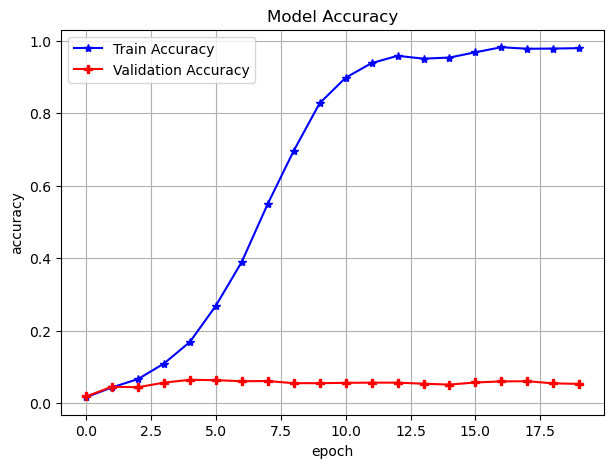

In [20]:
# graph of accuracy of training & validation data
plt.figure(figsize=(7,5))
plt.plot(first.history['accuracy'],label="Train Accuracy",color="blue",marker="*")
plt.plot(first.history['val_accuracy'],label="Validation Accuracy",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Looing at a graph of the training & validation loss

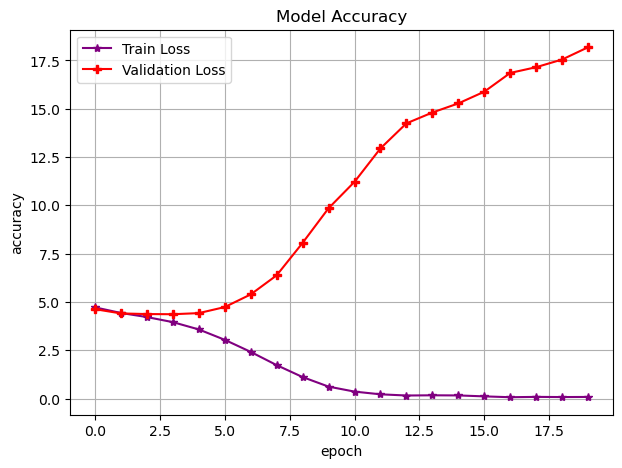

In [21]:
# graph of the loss of training & validation data
plt.figure(figsize=(7,5))
plt.plot(first.history['loss'],label="Train Loss",color="purple",marker="*")
plt.plot(first.history['val_loss'],label="Validation Loss",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Preprocess the testing images the same way as the training/validation set

In [22]:
# Preprocessing test images like the training set
# List all image files in the testing data path
test_image_files = os.listdir(test)

# Specify the image size
image_size = 100  # Adjust to your desired image size

# Preprocess testing data
test_data = np.zeros((len(test_image_files), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(test_image_files):
    img_path = os.path.join(test, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array and preprocess
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    test_data[i] = img_array

Make predictions using the testing images

# Make predictions on the testing data
predictions = base_model.predict(test_data)

Evaluating the model on the testing data: loss score
- ended up being useless

In [23]:
# Evaluate the model on the testing data
evaluation_results = base_model.evaluate(test_data)

# Extract the loss score
loss_score = evaluation_results[0]

# Print the loss score
print(f'Test Loss: {loss_score:.4f}')

324/324 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Loss: 0.0000


Wordcloud!

Some examples of predictions with the probability of the breed

### Top 10 comparison?

### Model Tuning

### Data Augmentation

### Train, Test Splits

### Final Model

### Pre-trained Model Comparison

### Conclusion
The current model is deemed unsuitable for production deployment due to its inconsistent performance and frequent incorrect predictions. Notably, there exists a substantial disparity in accuracy between the training and validation sets, approximately 15%.

### Next Steps
The following steps are planned to refine the model and enhance its performance:

1. Generating a label CSV for the testing data to enable comprehensive evaluation
2. Implementing further tuning strategies
    - Additional layers and/or nodes
    - Extending training duration
    - Leveraging pre-trained models to improve prediction accuracy
3. Incorporating mixed breeds into the model to broaden its scope and improve breed identification accuracy
4. Eventually transitioning to web app production to facilitate user-friendly interface & access